In [14]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder, MinMaxScaler, RobustScaler, MaxAbsScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.decomposition import PCA
from sklearn.utils.class_weight import compute_class_weight


from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

from xgboost import XGBClassifier, XGBRegressor
import xgboost as xgb
from tpot import TPOTClassifier

In [15]:
features_num = [
    'Total_flux', 'Peak_flux', 
       'NUV_flux_corr', 'u_flux_corr', 'Bw_flux_corr', 'R_flux_corr',
       'I_flux_corr', 'z_flux_corr', 'y_flux_corr',
       'J_flux_corr', 'H_flux_corr', 'K_flux_corr', 'Ks_flux_corr',
       'ch1_flux_corr', 'ch2_flux_corr', 'ch3_flux_corr', 'ch4_flux_corr',
       'F_MIPS_24', 'F_PACS_100', 'F_PACS_160', 'F_SPIRE_250', 'F_SPIRE_350',
       'F_SPIRE_500', 'Z_BEST',
       'g_flux_corr', 'nb921_hsc_flux_corr'
    ]
y_column = "Classification"

classes = ['jet-mode radio AGN/low-excitation radio galaxy', 'quasar-like radio AGN / high-excitation radio galaxy', 
           'radio-quiet AGN', 'star-forming galaxy']

In [16]:
data = pd.read_csv("../../../Data/Fangyou_data/Cleaned/combined_using_similar_columns.csv")
data['Source'] = 'Original'

In [17]:
X = data[features_num]
y = data[[y_column, 'Source', 'Xray', 'Opt_spec', 'IRAGN', 'Donley']]

In [18]:
le = LabelEncoder()
labels = np.unique(y["Classification"].astype(str))
y["Classification"] = le.fit_transform(y["Classification"])

/var/lib/condor/execute/dir_497728/ipykernel_497957/2943677748.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y["Classification"] = le.fit_transform(y["Classification"])


## BH data

In [19]:
Best_Heckman_data = pd.read_csv("../../../Data/Best&Heckman/BestHeckman+SDSS+wise+LOFAR_better_fixed_fluxes.csv")
Best_Heckman_data['Source'] = 'BH'

In [20]:
# Only selecting data with a classification
Best_Heckman_data = Best_Heckman_data[Best_Heckman_data['Classification'] != 'Radio-loud AGN'] 

In [21]:
Best_Heckman_X = Best_Heckman_data[[c for c in Best_Heckman_data.columns if c != 'Classification']]
Best_Heckman_y = Best_Heckman_data[['Classification', 'Source']]

In [22]:
Best_Heckman_y['Classification'] = le.transform(Best_Heckman_y['Classification'])

/var/lib/condor/execute/dir_497728/ipykernel_497957/4234724966.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Best_Heckman_y['Classification'] = le.transform(Best_Heckman_y['Classification'])


In [23]:
y = pd.concat([y, Best_Heckman_y]).reset_index(drop=True)

In [24]:
Best_Heckman_X = Best_Heckman_X[['Z_BEST', 'u_flux_corr',
       'g_flux_corr', 'R_flux_corr', 'I_flux_corr', 'z_flux_corr', 'ch1_flux_corr', 'ch2_flux_corr',
       'J_flux_corr', 'H_flux_corr', 'Ks_flux_corr', 'Peak_flux', 'Total_flux']]

# Adding nans to missing columns
Best_Heckman_X[['NUV_flux_corr', 'Bw_flux_corr', 'y_flux_corr', 'K_flux_corr', 
                'F_MIPS_24', 'F_PACS_100', 'F_PACS_160', 'F_SPIRE_250', 'F_SPIRE_350',
                'F_SPIRE_500', 'nb921_hsc_flux_corr', 'ch3_flux_corr', 'ch4_flux_corr']] = np.nan

In [25]:
X = pd.concat([X, Best_Heckman_X]).reset_index(drop=True)

### MIGHTEE data

In [26]:
mightee_data = pd.read_csv("../../../Data/MIGHTEE/Classification/final_gaussian_radio_more.csv")
mightee_data['Source'] = 'MIGHTEE'

In [27]:
# Dropping nan classifications
mightee_data = mightee_data[mightee_data['Classification'].notna()]

# Dropping quasar-like radio AGN / high-excitation radio galaxy
#mightee_data = mightee_data[mightee_data['Classification'] != 'star-forming galaxy']
print("Amount of rows:", len(mightee_data))

Amount of rows: 4370


In [28]:
mightee_X = mightee_data[[c for c in mightee_data.columns if c != 'Classification']]
mightee_y = mightee_data[['Classification', 'Source', 'XAGN', 'midIRAGN', 'VLBAAGN', 'RLAGN', 'optAGN']]

In [29]:
mightee_y['Classification'] = le.transform(mightee_y['Classification'])
y = pd.concat([y, mightee_y]).reset_index(drop=True)

/var/lib/condor/execute/dir_497728/ipykernel_497957/4111256676.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mightee_y['Classification'] = le.transform(mightee_y['Classification'])


In [30]:
mightee_X = mightee_X[['Z_BEST', 'ch1_flux_corr', 'ch2_flux_corr', 'ch3_flux_corr',
       'ch4_flux_corr', 'F_MIPS_24', 'F_PACS_100', 'F_PACS_160',
       'F_SPIRE_250', 'F_SPIRE_350', 'F_SPIRE_500', 'Ks_flux_corr',
       'H_flux_corr', 'J_flux_corr', 'i_flux_corr', 'r_flux_corr',
       'u_flux_corr', 'z_flux_corr', 'y_flux_corr', 'NUV_flux_corr',
       #'FUV_flux_corr', 
                       'Total_flux', 'Peak_flux']]

mightee_X[['I_flux_corr', 'R_flux_corr']] = mightee_X[['i_flux_corr', 'r_flux_corr']]
mightee_X = mightee_X.drop(columns=['i_flux_corr', 'r_flux_corr'])

# Adding nans to missing columns
mightee_X[['Bw_flux_corr', 'K_flux_corr', 'g_flux_corr', 'nb921_hsc_flux_corr']] = np.nan

# Changing order
mightee_X = mightee_X[['Total_flux', 'Peak_flux', 
                       'NUV_flux_corr', 'u_flux_corr', 
                       'Bw_flux_corr', 'R_flux_corr', 
                       'I_flux_corr', 'z_flux_corr', 
                       'y_flux_corr', 'J_flux_corr', 
                       'H_flux_corr', 'K_flux_corr', 
                       'Ks_flux_corr', 'ch1_flux_corr', 
                       'ch2_flux_corr', 'ch3_flux_corr', 
                       'ch4_flux_corr', 'F_MIPS_24', 'F_PACS_100', 
                       'F_PACS_160', 'F_SPIRE_250', 'F_SPIRE_350', 
                       'F_SPIRE_500', 'Z_BEST', 
                       'g_flux_corr', 'nb921_hsc_flux_corr']]

In [31]:
X = pd.concat([X, mightee_X]).reset_index(drop=True)

# Add binary columns

In [62]:
def binary(row):
    
    if row['Classification'] == 'jet-mode radio AGN/low-excitation radio galaxy':
        return 1, 0
    elif row['Classification'] == 'quasar-like radio AGN / high-excitation radio galaxy':
        return 1, 1
    elif row['Classification'] == 'radio-quiet AGN':
        return 0, 1
    elif row['Classification'] == 'star-forming galaxy':
        return 0, 0

In [63]:
# Temporarily relabelling it for function
y['Classification'] = le.inverse_transform(y['Classification'])
y[['Radio', 'Radiative']] =  y.apply(binary, axis=1, result_type='expand')
y['Classification'] = le.transform(y['Classification'])

In [64]:
y

,Classification,Source,Xray,Opt_spec,IRAGN,Donley,XAGN,midIRAGN,VLBAAGN,RLAGN,optAGN,Radio,Radiative
0,3,Original,0.0,0.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,0,0
1,1,Original,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,1,1
2,3,Original,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0,0
3,3,Original,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0,0
4,2,Original,0.0,0.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95136,3,MIGHTEE,NaN,NaN,NaN,NaN,False,False,False,False,False,0,0
95137,1,MIGHTEE,NaN,NaN,NaN,NaN,True,False,False,True,False,1,1
95138,3,MIGHTEE,NaN,NaN,NaN,NaN,False,False,False,False,False,0,0
95139,3,MIGHTEE,NaN,NaN,NaN,NaN,False,False,False,False,False,0,0


## Manual model

In [136]:
model = XGBClassifier(use_label_encoder=False, 
                      max_depth=3, 
                      reg_alpha=0,   
                      #min_child_weight=0.3662, 
                      #reg_lambda=3,
                      eta=0.05,
                      tree_method='hist',
                      #gpu_id=0,
                      #objective='multi:softprob',
                      eval_metric=['logloss', 'error'],
                      nthread=8,
                      n_estimators=10**5,
                      random_state=42
                      )

# Radio

In [138]:
eval_set = [(X_train, y_train['Radio']), (X_val, y_val['Radio'])]

In [139]:
model.fit(X_train, y_train['Radio'], verbose=True, eval_set=eval_set, early_stopping_rounds=50)

[0]	validation_0-logloss:0.66360	validation_0-error:0.13003	validation_1-logloss:0.66387	validation_1-error:0.12927
[1]	validation_0-logloss:0.63694	validation_0-error:0.12894	validation_1-logloss:0.63766	validation_1-error:0.13032
[2]	validation_0-logloss:0.61253	validation_0-error:0.11840	validation_1-logloss:0.61362	validation_1-error:0.11771
[3]	validation_0-logloss:0.59002	validation_0-error:0.12727	validation_1-logloss:0.59147	validation_1-error:0.12585
[4]	validation_0-logloss:0.56948	validation_0-error:0.11758	validation_1-logloss:0.57128	validation_1-error:0.11797
[5]	validation_0-logloss:0.55064	validation_0-error:0.11800	validation_1-logloss:0.55292	validation_1-error:0.11745
[6]	validation_0-logloss:0.53296	validation_0-error:0.12388	validation_1-logloss:0.53551	validation_1-error:0.12375
[7]	validation_0-logloss:0.51676	validation_0-error:0.12374	validation_1-logloss:0.51925	validation_1-error:0.12296
[8]	validation_0-logloss:0.50153	validation_0-error:0.11517	validation_1

[71]	validation_0-logloss:0.25933	validation_0-error:0.09684	validation_1-logloss:0.26694	validation_1-error:0.10483
[72]	validation_0-logloss:0.25852	validation_0-error:0.09671	validation_1-logloss:0.26619	validation_1-error:0.10536
[73]	validation_0-logloss:0.25785	validation_0-error:0.09707	validation_1-logloss:0.26559	validation_1-error:0.10510
[74]	validation_0-logloss:0.25703	validation_0-error:0.09679	validation_1-logloss:0.26470	validation_1-error:0.10431
[75]	validation_0-logloss:0.25630	validation_0-error:0.09670	validation_1-logloss:0.26404	validation_1-error:0.10483
[76]	validation_0-logloss:0.25552	validation_0-error:0.09588	validation_1-logloss:0.26330	validation_1-error:0.10431
[77]	validation_0-logloss:0.25437	validation_0-error:0.09524	validation_1-logloss:0.26206	validation_1-error:0.10352
[78]	validation_0-logloss:0.25354	validation_0-error:0.09524	validation_1-logloss:0.26123	validation_1-error:0.10378
[79]	validation_0-logloss:0.25274	validation_0-error:0.09508	val

[141]	validation_0-logloss:0.22109	validation_0-error:0.08519	validation_1-logloss:0.22948	validation_1-error:0.09222
[142]	validation_0-logloss:0.22078	validation_0-error:0.08523	validation_1-logloss:0.22912	validation_1-error:0.09249
[143]	validation_0-logloss:0.22049	validation_0-error:0.08510	validation_1-logloss:0.22882	validation_1-error:0.09222
[144]	validation_0-logloss:0.22007	validation_0-error:0.08498	validation_1-logloss:0.22858	validation_1-error:0.09117
[145]	validation_0-logloss:0.21979	validation_0-error:0.08480	validation_1-logloss:0.22832	validation_1-error:0.09091
[146]	validation_0-logloss:0.21944	validation_0-error:0.08457	validation_1-logloss:0.22795	validation_1-error:0.09144
[147]	validation_0-logloss:0.21913	validation_0-error:0.08461	validation_1-logloss:0.22769	validation_1-error:0.09170
[148]	validation_0-logloss:0.21887	validation_0-error:0.08453	validation_1-logloss:0.22740	validation_1-error:0.09144
[149]	validation_0-logloss:0.21844	validation_0-error:0.

[211]	validation_0-logloss:0.20119	validation_0-error:0.07836	validation_1-logloss:0.21083	validation_1-error:0.08303
[212]	validation_0-logloss:0.20091	validation_0-error:0.07831	validation_1-logloss:0.21066	validation_1-error:0.08250
[213]	validation_0-logloss:0.20054	validation_0-error:0.07825	validation_1-logloss:0.21019	validation_1-error:0.08329
[214]	validation_0-logloss:0.20033	validation_0-error:0.07815	validation_1-logloss:0.20998	validation_1-error:0.08329
[215]	validation_0-logloss:0.20016	validation_0-error:0.07817	validation_1-logloss:0.20982	validation_1-error:0.08303
[216]	validation_0-logloss:0.19998	validation_0-error:0.07809	validation_1-logloss:0.20970	validation_1-error:0.08355
[217]	validation_0-logloss:0.19979	validation_0-error:0.07803	validation_1-logloss:0.20952	validation_1-error:0.08303
[218]	validation_0-logloss:0.19958	validation_0-error:0.07787	validation_1-logloss:0.20928	validation_1-error:0.08303
[219]	validation_0-logloss:0.19938	validation_0-error:0.

[281]	validation_0-logloss:0.18902	validation_0-error:0.07387	validation_1-logloss:0.19967	validation_1-error:0.07909
[282]	validation_0-logloss:0.18891	validation_0-error:0.07380	validation_1-logloss:0.19958	validation_1-error:0.07935
[283]	validation_0-logloss:0.18883	validation_0-error:0.07380	validation_1-logloss:0.19949	validation_1-error:0.07909
[284]	validation_0-logloss:0.18864	validation_0-error:0.07361	validation_1-logloss:0.19929	validation_1-error:0.07935
[285]	validation_0-logloss:0.18843	validation_0-error:0.07352	validation_1-logloss:0.19909	validation_1-error:0.07909
[286]	validation_0-logloss:0.18813	validation_0-error:0.07334	validation_1-logloss:0.19873	validation_1-error:0.07882
[287]	validation_0-logloss:0.18796	validation_0-error:0.07325	validation_1-logloss:0.19866	validation_1-error:0.07882
[288]	validation_0-logloss:0.18784	validation_0-error:0.07322	validation_1-logloss:0.19859	validation_1-error:0.07830
[289]	validation_0-logloss:0.18770	validation_0-error:0.

[351]	validation_0-logloss:0.18031	validation_0-error:0.07028	validation_1-logloss:0.19187	validation_1-error:0.07619
[352]	validation_0-logloss:0.18020	validation_0-error:0.07025	validation_1-logloss:0.19178	validation_1-error:0.07619
[353]	validation_0-logloss:0.18007	validation_0-error:0.07017	validation_1-logloss:0.19162	validation_1-error:0.07619
[354]	validation_0-logloss:0.17994	validation_0-error:0.07013	validation_1-logloss:0.19157	validation_1-error:0.07672
[355]	validation_0-logloss:0.17986	validation_0-error:0.07016	validation_1-logloss:0.19146	validation_1-error:0.07672
[356]	validation_0-logloss:0.17971	validation_0-error:0.07012	validation_1-logloss:0.19129	validation_1-error:0.07672
[357]	validation_0-logloss:0.17958	validation_0-error:0.06991	validation_1-logloss:0.19112	validation_1-error:0.07672
[358]	validation_0-logloss:0.17954	validation_0-error:0.06988	validation_1-logloss:0.19112	validation_1-error:0.07672
[359]	validation_0-logloss:0.17930	validation_0-error:0.

[421]	validation_0-logloss:0.17368	validation_0-error:0.06754	validation_1-logloss:0.18611	validation_1-error:0.07330
[422]	validation_0-logloss:0.17359	validation_0-error:0.06748	validation_1-logloss:0.18604	validation_1-error:0.07357
[423]	validation_0-logloss:0.17354	validation_0-error:0.06744	validation_1-logloss:0.18603	validation_1-error:0.07357
[424]	validation_0-logloss:0.17346	validation_0-error:0.06737	validation_1-logloss:0.18601	validation_1-error:0.07357
[425]	validation_0-logloss:0.17341	validation_0-error:0.06740	validation_1-logloss:0.18598	validation_1-error:0.07357
[426]	validation_0-logloss:0.17330	validation_0-error:0.06732	validation_1-logloss:0.18594	validation_1-error:0.07357
[427]	validation_0-logloss:0.17320	validation_0-error:0.06727	validation_1-logloss:0.18583	validation_1-error:0.07383
[428]	validation_0-logloss:0.17311	validation_0-error:0.06722	validation_1-logloss:0.18577	validation_1-error:0.07330
[429]	validation_0-logloss:0.17292	validation_0-error:0.

[491]	validation_0-logloss:0.16782	validation_0-error:0.06517	validation_1-logloss:0.18156	validation_1-error:0.07042
[492]	validation_0-logloss:0.16774	validation_0-error:0.06517	validation_1-logloss:0.18152	validation_1-error:0.07042
[493]	validation_0-logloss:0.16767	validation_0-error:0.06517	validation_1-logloss:0.18148	validation_1-error:0.07042
[494]	validation_0-logloss:0.16759	validation_0-error:0.06509	validation_1-logloss:0.18135	validation_1-error:0.07042
[495]	validation_0-logloss:0.16753	validation_0-error:0.06513	validation_1-logloss:0.18130	validation_1-error:0.07042
[496]	validation_0-logloss:0.16739	validation_0-error:0.06505	validation_1-logloss:0.18120	validation_1-error:0.07042
[497]	validation_0-logloss:0.16735	validation_0-error:0.06502	validation_1-logloss:0.18111	validation_1-error:0.07042
[498]	validation_0-logloss:0.16732	validation_0-error:0.06504	validation_1-logloss:0.18111	validation_1-error:0.07042
[499]	validation_0-logloss:0.16726	validation_0-error:0.

[561]	validation_0-logloss:0.16303	validation_0-error:0.06335	validation_1-logloss:0.17780	validation_1-error:0.06884
[562]	validation_0-logloss:0.16301	validation_0-error:0.06334	validation_1-logloss:0.17779	validation_1-error:0.06884
[563]	validation_0-logloss:0.16297	validation_0-error:0.06335	validation_1-logloss:0.17778	validation_1-error:0.06936
[564]	validation_0-logloss:0.16292	validation_0-error:0.06330	validation_1-logloss:0.17777	validation_1-error:0.06936
[565]	validation_0-logloss:0.16284	validation_0-error:0.06322	validation_1-logloss:0.17772	validation_1-error:0.06910
[566]	validation_0-logloss:0.16280	validation_0-error:0.06322	validation_1-logloss:0.17768	validation_1-error:0.06963
[567]	validation_0-logloss:0.16272	validation_0-error:0.06318	validation_1-logloss:0.17760	validation_1-error:0.06884
[568]	validation_0-logloss:0.16264	validation_0-error:0.06321	validation_1-logloss:0.17754	validation_1-error:0.06884
[569]	validation_0-logloss:0.16257	validation_0-error:0.

[631]	validation_0-logloss:0.15846	validation_0-error:0.06141	validation_1-logloss:0.17411	validation_1-error:0.06779
[632]	validation_0-logloss:0.15832	validation_0-error:0.06144	validation_1-logloss:0.17400	validation_1-error:0.06779
[633]	validation_0-logloss:0.15828	validation_0-error:0.06140	validation_1-logloss:0.17399	validation_1-error:0.06805
[634]	validation_0-logloss:0.15815	validation_0-error:0.06133	validation_1-logloss:0.17388	validation_1-error:0.06831
[635]	validation_0-logloss:0.15808	validation_0-error:0.06127	validation_1-logloss:0.17383	validation_1-error:0.06831
[636]	validation_0-logloss:0.15805	validation_0-error:0.06130	validation_1-logloss:0.17379	validation_1-error:0.06831
[637]	validation_0-logloss:0.15798	validation_0-error:0.06132	validation_1-logloss:0.17376	validation_1-error:0.06831
[638]	validation_0-logloss:0.15792	validation_0-error:0.06121	validation_1-logloss:0.17371	validation_1-error:0.06831
[639]	validation_0-logloss:0.15787	validation_0-error:0.

[701]	validation_0-logloss:0.15494	validation_0-error:0.05999	validation_1-logloss:0.17163	validation_1-error:0.06674
[702]	validation_0-logloss:0.15489	validation_0-error:0.05996	validation_1-logloss:0.17159	validation_1-error:0.06647
[703]	validation_0-logloss:0.15485	validation_0-error:0.05996	validation_1-logloss:0.17158	validation_1-error:0.06674
[704]	validation_0-logloss:0.15480	validation_0-error:0.05996	validation_1-logloss:0.17156	validation_1-error:0.06674
[705]	validation_0-logloss:0.15477	validation_0-error:0.05996	validation_1-logloss:0.17156	validation_1-error:0.06674
[706]	validation_0-logloss:0.15472	validation_0-error:0.05987	validation_1-logloss:0.17155	validation_1-error:0.06674
[707]	validation_0-logloss:0.15466	validation_0-error:0.05981	validation_1-logloss:0.17150	validation_1-error:0.06674
[708]	validation_0-logloss:0.15462	validation_0-error:0.05975	validation_1-logloss:0.17146	validation_1-error:0.06647
[709]	validation_0-logloss:0.15461	validation_0-error:0.

[771]	validation_0-logloss:0.15186	validation_0-error:0.05861	validation_1-logloss:0.16975	validation_1-error:0.06621
[772]	validation_0-logloss:0.15181	validation_0-error:0.05860	validation_1-logloss:0.16972	validation_1-error:0.06542
[773]	validation_0-logloss:0.15176	validation_0-error:0.05857	validation_1-logloss:0.16963	validation_1-error:0.06569
[774]	validation_0-logloss:0.15167	validation_0-error:0.05853	validation_1-logloss:0.16956	validation_1-error:0.06595
[775]	validation_0-logloss:0.15162	validation_0-error:0.05854	validation_1-logloss:0.16953	validation_1-error:0.06647
[776]	validation_0-logloss:0.15157	validation_0-error:0.05849	validation_1-logloss:0.16948	validation_1-error:0.06647
[777]	validation_0-logloss:0.15153	validation_0-error:0.05845	validation_1-logloss:0.16946	validation_1-error:0.06647
[778]	validation_0-logloss:0.15150	validation_0-error:0.05843	validation_1-logloss:0.16945	validation_1-error:0.06647
[779]	validation_0-logloss:0.15147	validation_0-error:0.

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eta=0.05,
              eval_metric=['logloss', 'error'], gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.0500000007, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100000, n_jobs=8, nthread=8, num_parallel_tree=1,
              random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=1, tree_method='hist', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [140]:
hist = model.evals_result()

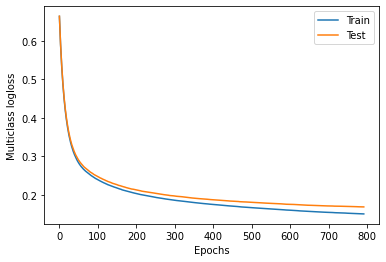

In [141]:
plt.plot(hist['validation_0']['logloss'], label='Train')
plt.plot(hist['validation_1']['logloss'], label='Test')

plt.xlabel('Epochs')
plt.ylabel('Multiclass logloss')
plt.legend()

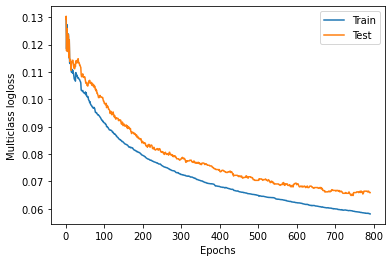

In [142]:
plt.plot(hist['validation_0']['error'], label='Train')
plt.plot(hist['validation_1']['error'], label='Test')

plt.xlabel('Epochs')
plt.ylabel('Multiclass logloss')
plt.legend()
#plt.ylim(0,1)

In [152]:
filt = y_test['Source']==y_test.Source.unique()[2]
print(classification_report(model.predict(X_test[filt]), y_test['Radio'][filt], digits=4))

              precision    recall  f1-score   support

           0     0.9258    0.8301    0.8753       571
           1     0.4813    0.7031    0.5714       128

    accuracy                         0.8069       699
   macro avg     0.7035    0.7666    0.7234       699
weighted avg     0.8444    0.8069    0.8197       699



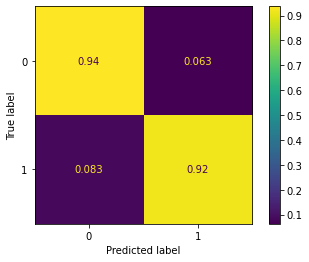

In [144]:
cm = confusion_matrix(model.predict(X_test), y_test['Radio'], normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

## SHAP

In [153]:
import shap
shap.initjs()

In [154]:
mapping = {'Total_flux': 'Total 150 MHz',
           'Peak_flux': 'Peak 150 MHz', 
           'NUV_flux_corr': 'NUV', 
           'u_flux_corr': 'u',
           'Bw_flux_corr': r'$B_w$', 
           'R_flux_corr': 'R', 
           'I_flux_corr': 'I', 
           'z_flux_corr': 'z',
           'y_flux_corr': 'y', 
           'J_flux_corr': 'J', 
           'H_flux_corr': 'H', 
           'K_flux_corr': 'K',
           'Ks_flux_corr': r'$K_s$', 
           'ch1_flux_corr': 'ch1', 
           'ch2_flux_corr': 'ch2', 
           'ch3_flux_corr': 'ch3',
           'ch4_flux_corr': 'ch4', 
           'F_MIPS_24': 'MIPS24', 
           'F_PACS_100': 'PACS100', 
           'F_PACS_160': 'PACS160', 
           'F_SPIRE_250': 'SPIRE250',
           'F_SPIRE_350': 'SPIRE350', 
           'F_SPIRE_500': 'SPIRE500', 
           'Z_BEST': 'Redshift', 
           'g_flux_corr': 'g',
           'nb921_hsc_flux_corr': 'NB921'}

In [155]:
shap_values = shap.TreeExplainer(model, check_additivity=False).shap_values(X_train, check_additivity=False)

In [156]:
import matplotlib
matplotlib.rcParams.update({'font.size': 22, "axes.labelsize": 200})

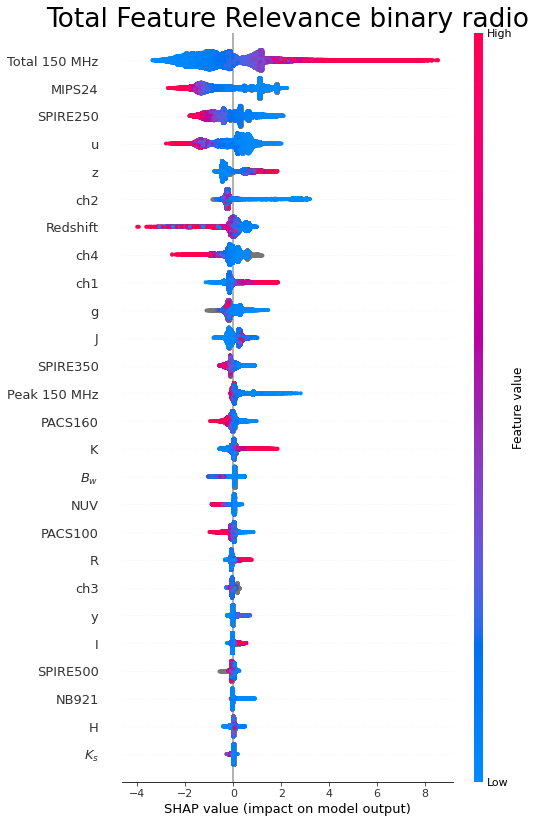

In [168]:
shap.summary_plot(shap_values, X_train.rename(columns=mapping), class_names=labels, max_display=999, show=False)
plt.title("Total Feature Relevance binary radio")
plt.tight_layout()
plt.savefig("Total_feature_relevance_binary_radio.pdf")

# Radiative

In [245]:
import matplotlib
matplotlib.rcParams.update(matplotlib.rcParamsDefault)

In [277]:
model = XGBClassifier(use_label_encoder=False, 
                      max_depth=4, 
                      reg_alpha=0,   
                      #min_child_weight=0.3662, 
                      #reg_lambda=3,
                      eta=0.05,
                      tree_method='hist',
                      #gpu_id=0,
                      #objective='multi:softprob',
                      eval_metric=['logloss', 'error'],
                      nthread=8,
                      n_estimators=10**5,
                      random_state=42
                      )

In [278]:
eval_set = [(X_train, y_train['Radiative']), (X_val, y_val['Radiative'])]

In [288]:
model.fit(X_train, y_train['Radiative'], verbose=True, eval_set=eval_set, early_stopping_rounds=200)

[0]	validation_0-logloss:0.65556	validation_0-error:0.07047	validation_1-logloss:0.65574	validation_1-error:0.07409
[1]	validation_0-logloss:0.62168	validation_0-error:0.07017	validation_1-logloss:0.62200	validation_1-error:0.07541
[2]	validation_0-logloss:0.59088	validation_0-error:0.06900	validation_1-logloss:0.59120	validation_1-error:0.07042
[3]	validation_0-logloss:0.56272	validation_0-error:0.06878	validation_1-logloss:0.56312	validation_1-error:0.07068
[4]	validation_0-logloss:0.53703	validation_0-error:0.06867	validation_1-logloss:0.53742	validation_1-error:0.07120
[5]	validation_0-logloss:0.51326	validation_0-error:0.06883	validation_1-logloss:0.51377	validation_1-error:0.07015
[6]	validation_0-logloss:0.49166	validation_0-error:0.06890	validation_1-logloss:0.49217	validation_1-error:0.06989
[7]	validation_0-logloss:0.47160	validation_0-error:0.06931	validation_1-logloss:0.47225	validation_1-error:0.07094
[8]	validation_0-logloss:0.45318	validation_0-error:0.06936	validation_1

[71]	validation_0-logloss:0.17534	validation_0-error:0.05983	validation_1-logloss:0.17793	validation_1-error:0.06385
[72]	validation_0-logloss:0.17473	validation_0-error:0.05985	validation_1-logloss:0.17735	validation_1-error:0.06385
[73]	validation_0-logloss:0.17414	validation_0-error:0.05973	validation_1-logloss:0.17678	validation_1-error:0.06385
[74]	validation_0-logloss:0.17359	validation_0-error:0.05961	validation_1-logloss:0.17622	validation_1-error:0.06358
[75]	validation_0-logloss:0.17286	validation_0-error:0.05950	validation_1-logloss:0.17539	validation_1-error:0.06358
[76]	validation_0-logloss:0.17234	validation_0-error:0.05936	validation_1-logloss:0.17501	validation_1-error:0.06306
[77]	validation_0-logloss:0.17181	validation_0-error:0.05927	validation_1-logloss:0.17457	validation_1-error:0.06280
[78]	validation_0-logloss:0.17130	validation_0-error:0.05931	validation_1-logloss:0.17403	validation_1-error:0.06358
[79]	validation_0-logloss:0.17080	validation_0-error:0.05924	val

[141]	validation_0-logloss:0.15092	validation_0-error:0.05575	validation_1-logloss:0.15758	validation_1-error:0.05859
[142]	validation_0-logloss:0.15076	validation_0-error:0.05563	validation_1-logloss:0.15744	validation_1-error:0.05885
[143]	validation_0-logloss:0.15060	validation_0-error:0.05563	validation_1-logloss:0.15733	validation_1-error:0.05859
[144]	validation_0-logloss:0.15025	validation_0-error:0.05556	validation_1-logloss:0.15716	validation_1-error:0.05859
[145]	validation_0-logloss:0.15012	validation_0-error:0.05554	validation_1-logloss:0.15704	validation_1-error:0.05859
[146]	validation_0-logloss:0.14993	validation_0-error:0.05545	validation_1-logloss:0.15703	validation_1-error:0.05833
[147]	validation_0-logloss:0.14974	validation_0-error:0.05537	validation_1-logloss:0.15693	validation_1-error:0.05833
[148]	validation_0-logloss:0.14952	validation_0-error:0.05533	validation_1-logloss:0.15674	validation_1-error:0.05833
[149]	validation_0-logloss:0.14933	validation_0-error:0.

[211]	validation_0-logloss:0.14005	validation_0-error:0.05257	validation_1-logloss:0.15057	validation_1-error:0.05754
[212]	validation_0-logloss:0.13993	validation_0-error:0.05253	validation_1-logloss:0.15048	validation_1-error:0.05754
[213]	validation_0-logloss:0.13986	validation_0-error:0.05251	validation_1-logloss:0.15043	validation_1-error:0.05728
[214]	validation_0-logloss:0.13976	validation_0-error:0.05250	validation_1-logloss:0.15044	validation_1-error:0.05728
[215]	validation_0-logloss:0.13957	validation_0-error:0.05241	validation_1-logloss:0.15033	validation_1-error:0.05728
[216]	validation_0-logloss:0.13947	validation_0-error:0.05241	validation_1-logloss:0.15020	validation_1-error:0.05728
[217]	validation_0-logloss:0.13940	validation_0-error:0.05236	validation_1-logloss:0.15014	validation_1-error:0.05728
[218]	validation_0-logloss:0.13921	validation_0-error:0.05237	validation_1-logloss:0.15000	validation_1-error:0.05702
[219]	validation_0-logloss:0.13911	validation_0-error:0.

[281]	validation_0-logloss:0.13300	validation_0-error:0.05023	validation_1-logloss:0.14668	validation_1-error:0.05649
[282]	validation_0-logloss:0.13292	validation_0-error:0.05018	validation_1-logloss:0.14662	validation_1-error:0.05649
[283]	validation_0-logloss:0.13282	validation_0-error:0.05004	validation_1-logloss:0.14663	validation_1-error:0.05649
[284]	validation_0-logloss:0.13272	validation_0-error:0.05007	validation_1-logloss:0.14656	validation_1-error:0.05623
[285]	validation_0-logloss:0.13267	validation_0-error:0.05007	validation_1-logloss:0.14656	validation_1-error:0.05649
[286]	validation_0-logloss:0.13256	validation_0-error:0.04998	validation_1-logloss:0.14651	validation_1-error:0.05596
[287]	validation_0-logloss:0.13247	validation_0-error:0.04990	validation_1-logloss:0.14646	validation_1-error:0.05596
[288]	validation_0-logloss:0.13232	validation_0-error:0.04993	validation_1-logloss:0.14638	validation_1-error:0.05596
[289]	validation_0-logloss:0.13218	validation_0-error:0.

[351]	validation_0-logloss:0.12710	validation_0-error:0.04817	validation_1-logloss:0.14375	validation_1-error:0.05518
[352]	validation_0-logloss:0.12700	validation_0-error:0.04813	validation_1-logloss:0.14376	validation_1-error:0.05544
[353]	validation_0-logloss:0.12690	validation_0-error:0.04813	validation_1-logloss:0.14368	validation_1-error:0.05544
[354]	validation_0-logloss:0.12683	validation_0-error:0.04811	validation_1-logloss:0.14369	validation_1-error:0.05544
[355]	validation_0-logloss:0.12676	validation_0-error:0.04801	validation_1-logloss:0.14367	validation_1-error:0.05544
[356]	validation_0-logloss:0.12670	validation_0-error:0.04797	validation_1-logloss:0.14366	validation_1-error:0.05544
[357]	validation_0-logloss:0.12662	validation_0-error:0.04797	validation_1-logloss:0.14366	validation_1-error:0.05544
[358]	validation_0-logloss:0.12651	validation_0-error:0.04798	validation_1-logloss:0.14361	validation_1-error:0.05544
[359]	validation_0-logloss:0.12646	validation_0-error:0.

[421]	validation_0-logloss:0.12217	validation_0-error:0.04616	validation_1-logloss:0.14133	validation_1-error:0.05491
[422]	validation_0-logloss:0.12213	validation_0-error:0.04618	validation_1-logloss:0.14131	validation_1-error:0.05491
[423]	validation_0-logloss:0.12204	validation_0-error:0.04621	validation_1-logloss:0.14125	validation_1-error:0.05518
[424]	validation_0-logloss:0.12202	validation_0-error:0.04621	validation_1-logloss:0.14127	validation_1-error:0.05491
[425]	validation_0-logloss:0.12198	validation_0-error:0.04617	validation_1-logloss:0.14128	validation_1-error:0.05465
[426]	validation_0-logloss:0.12193	validation_0-error:0.04619	validation_1-logloss:0.14120	validation_1-error:0.05491
[427]	validation_0-logloss:0.12186	validation_0-error:0.04621	validation_1-logloss:0.14115	validation_1-error:0.05465
[428]	validation_0-logloss:0.12175	validation_0-error:0.04606	validation_1-logloss:0.14111	validation_1-error:0.05465
[429]	validation_0-logloss:0.12169	validation_0-error:0.

[491]	validation_0-logloss:0.11809	validation_0-error:0.04497	validation_1-logloss:0.13975	validation_1-error:0.05439
[492]	validation_0-logloss:0.11804	validation_0-error:0.04499	validation_1-logloss:0.13972	validation_1-error:0.05439
[493]	validation_0-logloss:0.11797	validation_0-error:0.04492	validation_1-logloss:0.13971	validation_1-error:0.05439
[494]	validation_0-logloss:0.11789	validation_0-error:0.04491	validation_1-logloss:0.13970	validation_1-error:0.05439
[495]	validation_0-logloss:0.11782	validation_0-error:0.04480	validation_1-logloss:0.13967	validation_1-error:0.05491
[496]	validation_0-logloss:0.11777	validation_0-error:0.04482	validation_1-logloss:0.13963	validation_1-error:0.05491
[497]	validation_0-logloss:0.11768	validation_0-error:0.04468	validation_1-logloss:0.13962	validation_1-error:0.05465
[498]	validation_0-logloss:0.11759	validation_0-error:0.04459	validation_1-logloss:0.13954	validation_1-error:0.05439
[499]	validation_0-logloss:0.11752	validation_0-error:0.

[561]	validation_0-logloss:0.11410	validation_0-error:0.04331	validation_1-logloss:0.13857	validation_1-error:0.05307
[562]	validation_0-logloss:0.11404	validation_0-error:0.04320	validation_1-logloss:0.13853	validation_1-error:0.05307
[563]	validation_0-logloss:0.11399	validation_0-error:0.04321	validation_1-logloss:0.13852	validation_1-error:0.05307
[564]	validation_0-logloss:0.11391	validation_0-error:0.04324	validation_1-logloss:0.13842	validation_1-error:0.05307
[565]	validation_0-logloss:0.11386	validation_0-error:0.04323	validation_1-logloss:0.13841	validation_1-error:0.05307
[566]	validation_0-logloss:0.11378	validation_0-error:0.04323	validation_1-logloss:0.13831	validation_1-error:0.05307
[567]	validation_0-logloss:0.11372	validation_0-error:0.04312	validation_1-logloss:0.13828	validation_1-error:0.05307
[568]	validation_0-logloss:0.11367	validation_0-error:0.04312	validation_1-logloss:0.13827	validation_1-error:0.05307
[569]	validation_0-logloss:0.11360	validation_0-error:0.

[631]	validation_0-logloss:0.11069	validation_0-error:0.04212	validation_1-logloss:0.13768	validation_1-error:0.05202
[632]	validation_0-logloss:0.11064	validation_0-error:0.04217	validation_1-logloss:0.13766	validation_1-error:0.05229
[633]	validation_0-logloss:0.11059	validation_0-error:0.04212	validation_1-logloss:0.13766	validation_1-error:0.05176
[634]	validation_0-logloss:0.11054	validation_0-error:0.04212	validation_1-logloss:0.13765	validation_1-error:0.05176
[635]	validation_0-logloss:0.11050	validation_0-error:0.04210	validation_1-logloss:0.13766	validation_1-error:0.05176
[636]	validation_0-logloss:0.11046	validation_0-error:0.04208	validation_1-logloss:0.13768	validation_1-error:0.05150
[637]	validation_0-logloss:0.11042	validation_0-error:0.04206	validation_1-logloss:0.13767	validation_1-error:0.05202
[638]	validation_0-logloss:0.11038	validation_0-error:0.04206	validation_1-logloss:0.13769	validation_1-error:0.05202
[639]	validation_0-logloss:0.11036	validation_0-error:0.

[701]	validation_0-logloss:0.10762	validation_0-error:0.04068	validation_1-logloss:0.13703	validation_1-error:0.05281
[702]	validation_0-logloss:0.10759	validation_0-error:0.04068	validation_1-logloss:0.13702	validation_1-error:0.05281
[703]	validation_0-logloss:0.10754	validation_0-error:0.04064	validation_1-logloss:0.13705	validation_1-error:0.05281
[704]	validation_0-logloss:0.10753	validation_0-error:0.04064	validation_1-logloss:0.13706	validation_1-error:0.05281
[705]	validation_0-logloss:0.10746	validation_0-error:0.04056	validation_1-logloss:0.13702	validation_1-error:0.05229
[706]	validation_0-logloss:0.10743	validation_0-error:0.04052	validation_1-logloss:0.13700	validation_1-error:0.05229
[707]	validation_0-logloss:0.10738	validation_0-error:0.04053	validation_1-logloss:0.13697	validation_1-error:0.05229
[708]	validation_0-logloss:0.10733	validation_0-error:0.04051	validation_1-logloss:0.13694	validation_1-error:0.05255
[709]	validation_0-logloss:0.10728	validation_0-error:0.

[771]	validation_0-logloss:0.10444	validation_0-error:0.03910	validation_1-logloss:0.13622	validation_1-error:0.05176
[772]	validation_0-logloss:0.10439	validation_0-error:0.03904	validation_1-logloss:0.13625	validation_1-error:0.05176
[773]	validation_0-logloss:0.10434	validation_0-error:0.03902	validation_1-logloss:0.13622	validation_1-error:0.05176
[774]	validation_0-logloss:0.10430	validation_0-error:0.03902	validation_1-logloss:0.13621	validation_1-error:0.05176
[775]	validation_0-logloss:0.10426	validation_0-error:0.03904	validation_1-logloss:0.13621	validation_1-error:0.05176
[776]	validation_0-logloss:0.10422	validation_0-error:0.03902	validation_1-logloss:0.13621	validation_1-error:0.05176
[777]	validation_0-logloss:0.10420	validation_0-error:0.03900	validation_1-logloss:0.13620	validation_1-error:0.05176
[778]	validation_0-logloss:0.10416	validation_0-error:0.03900	validation_1-logloss:0.13622	validation_1-error:0.05176
[779]	validation_0-logloss:0.10413	validation_0-error:0.

[841]	validation_0-logloss:0.10145	validation_0-error:0.03764	validation_1-logloss:0.13563	validation_1-error:0.05071
[842]	validation_0-logloss:0.10140	validation_0-error:0.03756	validation_1-logloss:0.13557	validation_1-error:0.05097
[843]	validation_0-logloss:0.10135	validation_0-error:0.03750	validation_1-logloss:0.13552	validation_1-error:0.05124
[844]	validation_0-logloss:0.10129	validation_0-error:0.03748	validation_1-logloss:0.13547	validation_1-error:0.05124
[845]	validation_0-logloss:0.10126	validation_0-error:0.03750	validation_1-logloss:0.13545	validation_1-error:0.05124
[846]	validation_0-logloss:0.10122	validation_0-error:0.03747	validation_1-logloss:0.13544	validation_1-error:0.05124
[847]	validation_0-logloss:0.10119	validation_0-error:0.03746	validation_1-logloss:0.13541	validation_1-error:0.05124
[848]	validation_0-logloss:0.10115	validation_0-error:0.03743	validation_1-logloss:0.13539	validation_1-error:0.05124
[849]	validation_0-logloss:0.10111	validation_0-error:0.

[911]	validation_0-logloss:0.09891	validation_0-error:0.03637	validation_1-logloss:0.13525	validation_1-error:0.05124
[912]	validation_0-logloss:0.09888	validation_0-error:0.03630	validation_1-logloss:0.13525	validation_1-error:0.05124
[913]	validation_0-logloss:0.09883	validation_0-error:0.03633	validation_1-logloss:0.13528	validation_1-error:0.05097
[914]	validation_0-logloss:0.09880	validation_0-error:0.03632	validation_1-logloss:0.13524	validation_1-error:0.05097
[915]	validation_0-logloss:0.09876	validation_0-error:0.03632	validation_1-logloss:0.13526	validation_1-error:0.05097
[916]	validation_0-logloss:0.09873	validation_0-error:0.03633	validation_1-logloss:0.13528	validation_1-error:0.05097
[917]	validation_0-logloss:0.09869	validation_0-error:0.03633	validation_1-logloss:0.13532	validation_1-error:0.05097
[918]	validation_0-logloss:0.09865	validation_0-error:0.03634	validation_1-logloss:0.13535	validation_1-error:0.05097
[919]	validation_0-logloss:0.09860	validation_0-error:0.

[981]	validation_0-logloss:0.09655	validation_0-error:0.03524	validation_1-logloss:0.13503	validation_1-error:0.05124
[982]	validation_0-logloss:0.09652	validation_0-error:0.03524	validation_1-logloss:0.13500	validation_1-error:0.05150
[983]	validation_0-logloss:0.09648	validation_0-error:0.03522	validation_1-logloss:0.13503	validation_1-error:0.05150
[984]	validation_0-logloss:0.09644	validation_0-error:0.03525	validation_1-logloss:0.13503	validation_1-error:0.05124
[985]	validation_0-logloss:0.09640	validation_0-error:0.03522	validation_1-logloss:0.13501	validation_1-error:0.05124
[986]	validation_0-logloss:0.09637	validation_0-error:0.03524	validation_1-logloss:0.13501	validation_1-error:0.05150
[987]	validation_0-logloss:0.09634	validation_0-error:0.03528	validation_1-logloss:0.13505	validation_1-error:0.05176
[988]	validation_0-logloss:0.09631	validation_0-error:0.03522	validation_1-logloss:0.13507	validation_1-error:0.05176
[989]	validation_0-logloss:0.09627	validation_0-error:0.

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eta=0.05,
              eval_metric=['logloss', 'error'], gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.0500000007, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100000, n_jobs=8, nthread=8, num_parallel_tree=1,
              random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=1, tree_method='hist', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [289]:
hist = model.evals_result()

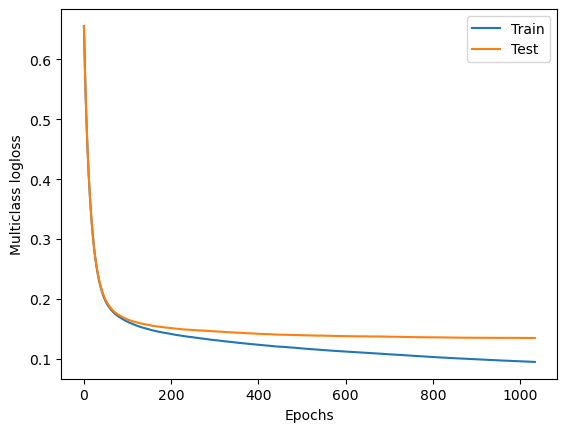

In [290]:
plt.plot(hist['validation_0']['logloss'], label='Train')
plt.plot(hist['validation_1']['logloss'], label='Test')

plt.xlabel('Epochs')
plt.ylabel('Logloss')
plt.legend()

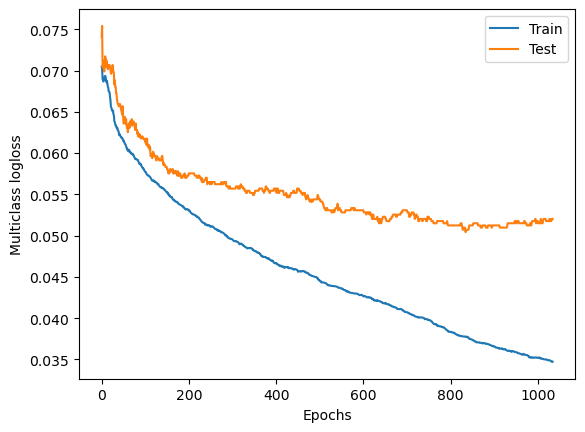

In [291]:
plt.plot(hist['validation_0']['error'], label='Train')
plt.plot(hist['validation_1']['error'], label='Test')

plt.xlabel('Epochs')
plt.ylabel('Error')
plt.legend()
#plt.ylim(0,1)

In [292]:
print(classification_report(model.predict(X_test), y_test['Radiative'], digits=4))

              precision    recall  f1-score   support

           0     0.9853    0.9623    0.9736     14101
           1     0.6334    0.8191    0.7143      1122

    accuracy                         0.9517     15223
   macro avg     0.8093    0.8907    0.8440     15223
weighted avg     0.9593    0.9517    0.9545     15223



In [293]:
filt = y_test['Source']==y_test.Source.unique()[0]
print(classification_report(model.predict(X_test[filt]), y_test['Radiative'][filt], digits=4))

              precision    recall  f1-score   support

           0     0.9827    0.9649    0.9737     11353
           1     0.6866    0.8188    0.7469      1065

    accuracy                         0.9524     12418
   macro avg     0.8347    0.8919    0.8603     12418
weighted avg     0.9573    0.9524    0.9543     12418



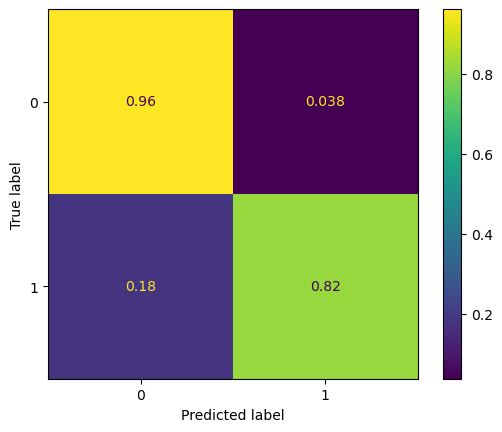

In [294]:
cm = confusion_matrix(model.predict(X_test), y_test['Radiative'], normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

## SHAP

In [295]:
import shap
shap.initjs()

In [296]:
shap_values = shap.TreeExplainer(model, check_additivity=False).shap_values(X_train, check_additivity=False)

In [297]:
import matplotlib
matplotlib.rcParams.update({'font.size': 22, "axes.labelsize": 200})

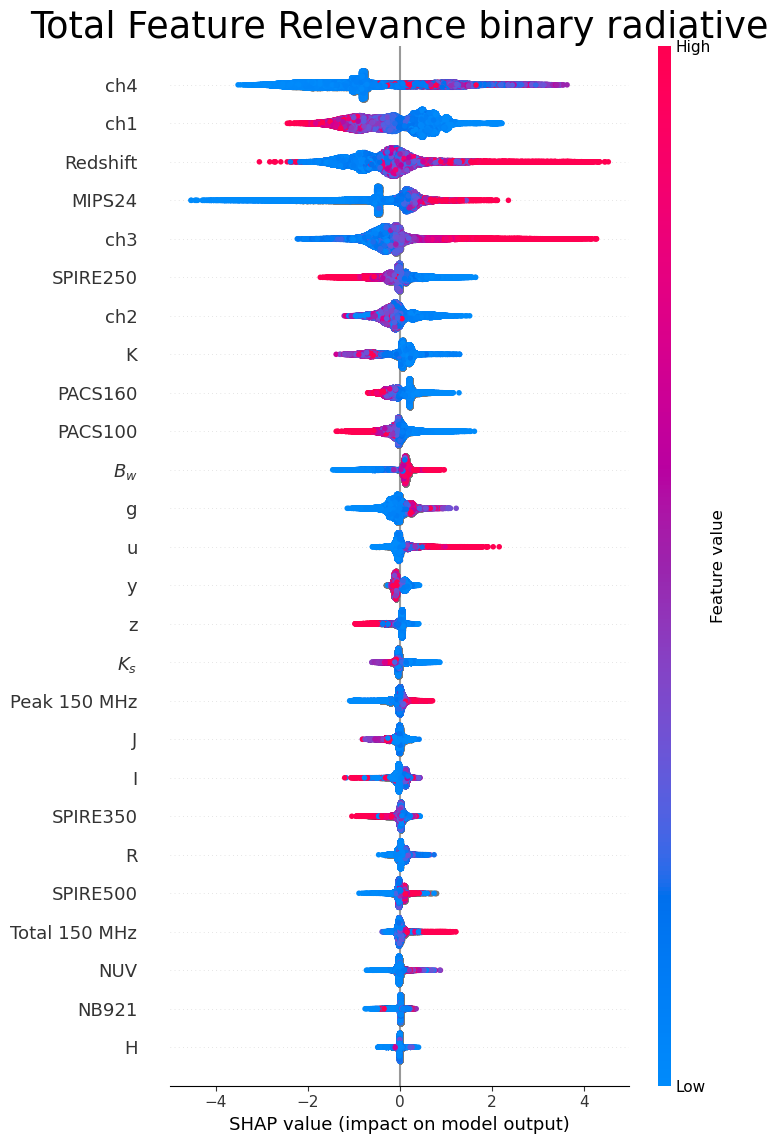

In [298]:
shap.summary_plot(shap_values, X_train.rename(columns=mapping), class_names=labels, max_display=999, show=False)
plt.title("Total Feature Relevance binary radiative")
plt.tight_layout()
plt.savefig("Total_feature_relevance_binary_radiative.pdf")

# Combined